<a href="https://www.kaggle.com/code/danieleldan/spaceship-titanic?scriptVersionId=104477473" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## THIS NOTEBOOK IS BEING CONSTANTLY UPDATED, SO I TRY TO "CUT" SOME ADVANCE AND PUBLISH A VERSION THAT WORKS.

In [1]:
import numpy as np
import pandas as pd
import re
import time

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import matplotlib.pyplot as plt


**Load data**

In [2]:
# Load data
train_df = pd.read_csv("../input/spaceship-titanic/train.csv")
test_df = pd.read_csv("../input/spaceship-titanic/test.csv")


In [3]:
# Save PassengersId for later
Passengers_Id = test_df["PassengerId"]

# **EXPLORATORY DATA ANALISYS**

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



**Split PassengerId in Ticket and Unique. This is because "grouped tickets"**

In [6]:
train_df[['PassengerId_Ticket', 'PassengerId_Unique']] = train_df['PassengerId'].str.split('_', expand=True)
test_df[['PassengerId_Ticket', 'PassengerId_Unique']] = test_df['PassengerId'].str.split('_', expand=True)



**Create a new column to identify people who travel in group**

In [7]:
# Train df first
serie = []
for i in train_df["PassengerId_Ticket"].values:
    if i in train_df["PassengerId_Ticket"][train_df["PassengerId_Ticket"].duplicated(keep="last")].array:
        serie = np.append(serie,True)
    else:
        serie = np.append(serie,False)
        
train_df['IsGrouped'] = serie.tolist()
train_df = train_df.astype({"IsGrouped": bool})

# Test df

serie = []
for i in test_df["PassengerId_Ticket"].values:
    if i in test_df["PassengerId_Ticket"][test_df["PassengerId_Ticket"].duplicated(keep="last")].array:
        serie = np.append(serie,True)
    else:
        serie = np.append(serie,False)
        
test_df['IsGrouped'] = serie.tolist()
test_df = test_df.astype({"IsGrouped": bool})

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,False


## **PLOT THIS FIRST APROACH TO THE DATAFRAME**

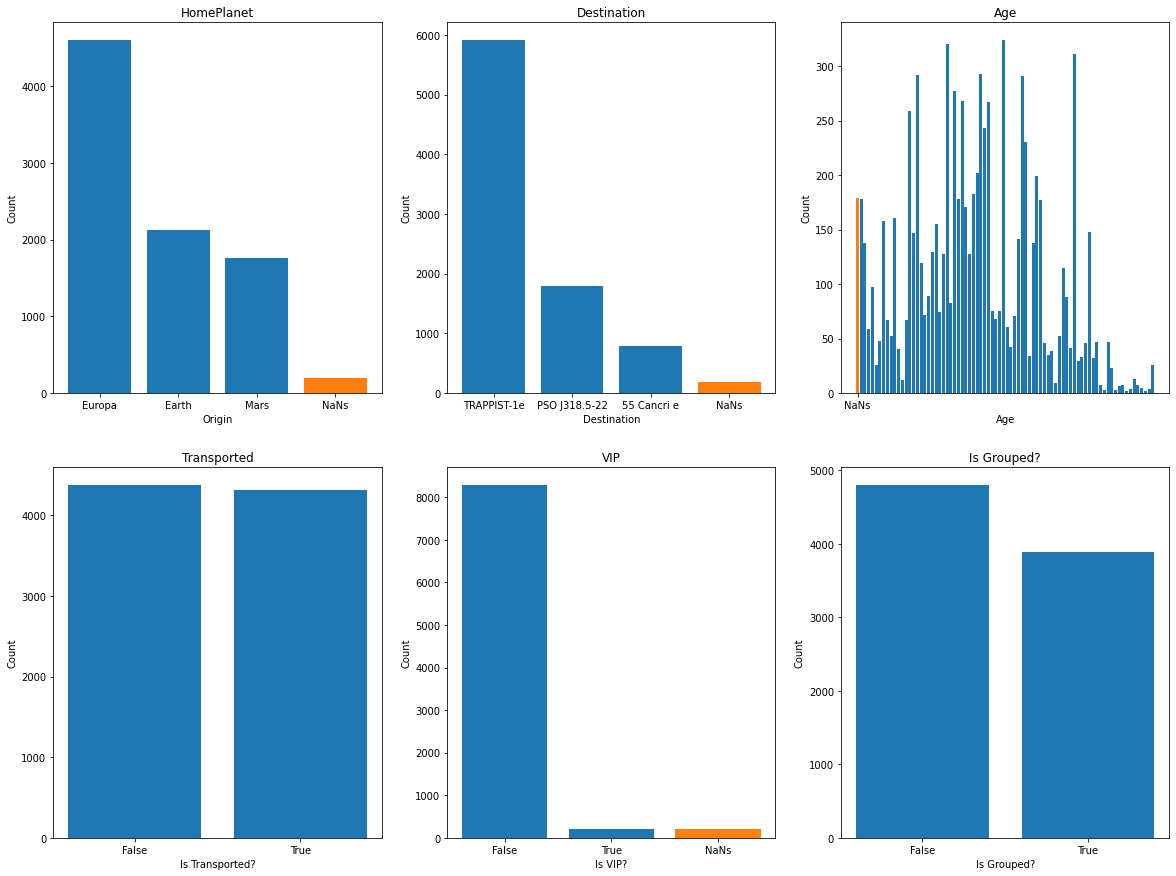

In [9]:
plt.figure()

plt.subplot(2,3,1)
plt.bar(train_df["HomePlanet"].dropna().unique(),train_df["HomePlanet"].value_counts())
plt.bar("NaNs",train_df["HomePlanet"].isna().sum())
plt.title("HomePlanet")
plt.xlabel("Origin")
plt.ylabel("Count")

plt.subplot(2,3,2)
plt.bar(train_df["Destination"].dropna().unique(),train_df["Destination"].value_counts())
plt.bar("NaNs",train_df["Destination"].isna().sum())
plt.title("Destination")
plt.xlabel("Destination")
plt.ylabel("Count")

plt.subplot(2,3,3)
plt.bar(train_df["Age"].dropna().unique(),train_df["Age"].value_counts())
plt.bar("NaNs",train_df["Age"].isna().sum())
plt.title("Age")
plt.xlabel("Age")
plt.ylabel("Count")

plt.subplot(2,3,4)
plt.bar(["False","True"],train_df["Transported"].value_counts())
plt.title("Transported")
plt.ylabel("Count")
plt.xlabel("Is Transported?")

plt.subplot(2,3,5)
plt.bar(["False","True"],train_df["VIP"].value_counts())
plt.bar("NaNs",train_df["VIP"].isna().sum())
plt.title("VIP")
plt.ylabel("Count")
plt.xlabel("Is VIP?")

plt.subplot(2,3,6)
plt.bar(["False","True"],train_df["IsGrouped"].value_counts())
plt.title("Is Grouped?")
plt.ylabel("Count")
plt.xlabel("Is Grouped?")

plt.rcParams["figure.figsize"] = (20,15)
plt.show()

**How much NaNs do we have?**

In [10]:
train_df.isna().sum()

PassengerId             0
HomePlanet            201
CryoSleep             217
Cabin                 199
Destination           182
Age                   179
VIP                   203
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Name                  200
Transported             0
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
dtype: int64


**CONTINUE to clean the DataFrame. Imputer help us to get rid of NaNs**

In [11]:
# Fill NaNs with mean value of each columns
imputer = SimpleImputer(strategy='mean')

train_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = imputer.fit_transform(train_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])
test_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = imputer.fit_transform(test_df[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])

#Fill NaNs with most frequent value of each columns
imputer = SimpleImputer(strategy='most_frequent')

train_df[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']] = imputer.fit_transform(train_df[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']])
test_df[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']] = imputer.fit_transform(test_df[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']])


**Split Cabin deck/num/side in three different columns**

In [12]:
# Split Cabin deck/num/side in three different columns

train_df[['Deck', 'Num', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
test_df[['Deck', 'Num', 'Side']] = test_df['Cabin'].str.split('/', expand=True)

In [13]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,False,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,True,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,True,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,False,F,1,S


**Change "object" type to category for further management**

In [14]:
train_df[['HomePlanet', 'Destination', 'Deck', 'Side']] = train_df[['HomePlanet', 'Destination', 'Deck', 'Side']].astype('category')
train_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = train_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')
train_df[['CryoSleep', 'VIP']] = train_df[['CryoSleep', 'VIP']].astype('bool')

test_df[['HomePlanet', 'Destination', 'Deck', 'Side']] = test_df[['HomePlanet', 'Destination', 'Deck', 'Side']].astype('category')
test_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = test_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')
test_df[['CryoSleep', 'VIP']] = test_df[['CryoSleep', 'VIP']].astype('bool')


**Plot of new data before scaling it**

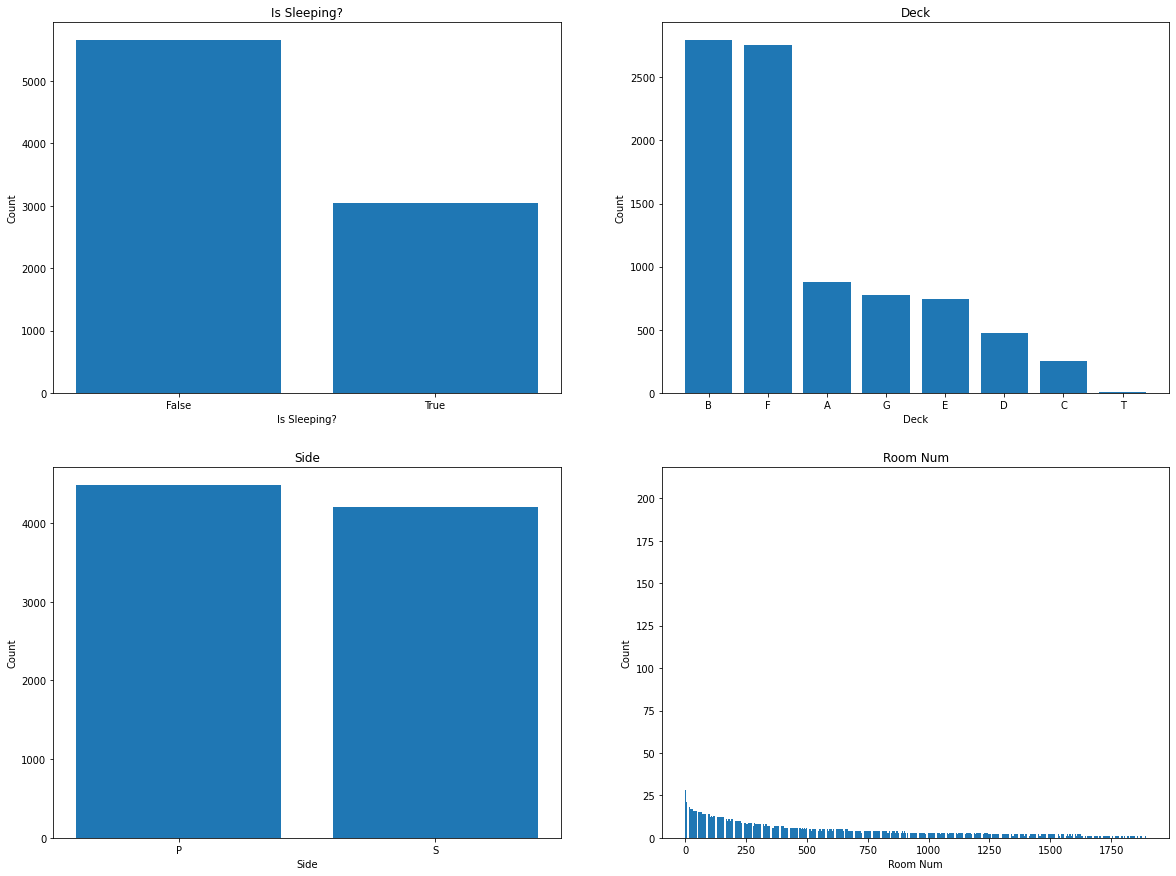

In [15]:
plt.figure()

plt.subplot(2,2,1)
plt.bar(["False","True"],train_df["CryoSleep"].value_counts())
plt.title("Is Sleeping?")
plt.ylabel("Count")
plt.xlabel("Is Sleeping?")

plt.subplot(2,2,2)
plt.bar(train_df["Deck"].dropna().unique(),train_df["Deck"].value_counts())
plt.title("Deck")
plt.xlabel("Deck")
plt.ylabel("Count")

plt.subplot(2,2,3)
plt.bar(train_df["Side"].dropna().unique(),train_df["Side"].value_counts())
plt.title("Side")
plt.xlabel("Side")
plt.ylabel("Count")

plt.subplot(2,2,4)
plt.bar(train_df["Num"].unique(),train_df["Num"].value_counts())
plt.title("Room Num")
plt.xlabel("Room Num")
plt.ylabel("Count")

plt.show()

**Label categorical data to standarize everything (Deck, Side).**

In [16]:
label_encoder = LabelEncoder()

for i in list(train_df.columns):
    if train_df[i].dtype=='category':
        train_df[i]=label_encoder.fit_transform(train_df[i])

for i in list(test_df.columns):
    if test_df[i].dtype=='category':
        test_df[i]=label_encoder.fit_transform(test_df[i])

In [17]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side
0,0001_01,1,False,B/0/P,2,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,False,1,0,0
1,0002_01,0,False,F/0/S,2,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,False,5,0,1
2,0003_01,1,False,A/0/S,2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1,True,0,0,1
3,0003_02,1,False,A/0/S,2,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2,True,0,0,1
4,0004_01,0,False,F/1/S,2,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1,False,5,1,1


**Here we make scaler to adjust the numeric data**

In [19]:
mask = ['HomePlanet','Destination','Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerId_Ticket', 'PassengerId_Unique', 'Deck', 'Num', 'Side']
scaler = MinMaxScaler()

# Scale train df
scaler.fit(train_df[mask])
train_df[mask] = scaler.transform(train_df[mask])

# Scale test df
scaler.fit(test_df[mask])
test_df[mask] = scaler.transform(test_df[mask])

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side
0,0001_01,0.5,False,B/0/P,1.0,0.493671,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,0.000000,0.000000,False,0.142857,0.000000,0.0
1,0002_01,0.0,False,F/0/S,1.0,0.303797,False,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,True,0.000108,0.000000,False,0.714286,0.000000,1.0
2,0003_01,0.5,False,A/0/S,1.0,0.734177,True,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,False,0.000216,0.000000,True,0.000000,0.000000,1.0
3,0003_02,0.5,False,A/0/S,1.0,0.417722,False,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,False,0.000216,0.142857,True,0.000000,0.000000,1.0
4,0004_01,0.0,False,F/1/S,1.0,0.202532,False,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,True,0.000323,0.000000,False,0.714286,0.000528,1.0


**We don't need Cabin or Name anymore**

In [20]:
train_df = train_df.drop('Cabin', axis=1)
train_df = train_df.drop('Name', axis=1)

test_df = test_df.drop('Name', axis=1)
test_df = test_df.drop('Cabin', axis=1)

**Now transform bool data into 0 and 1s**

In [21]:
onehot = OneHotEncoder()

for i in list(train_df.columns):
    if train_df[i].dtype=='bool':
        train_df[i]=label_encoder.fit_transform(train_df[i])
        
for i in list(test_df.columns):
    if test_df[i].dtype=='bool':
        test_df[i]=label_encoder.fit_transform(test_df[i])

**Now we got just numericall data**
FINAL TRAIN DATA FRAME

In [22]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side
0,0001_01,0.5,0,1.0,0.493671,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.142857,0.000000,0.0
1,0002_01,0.0,0,1.0,0.303797,0,0.007608,0.000302,0.001064,0.024500,0.001823,1,0.000108,0.000000,0,0.714286,0.000000,1.0
2,0003_01,0.5,0,1.0,0.734177,1,0.003001,0.119948,0.000000,0.299670,0.002030,0,0.000216,0.000000,1,0.000000,0.000000,1.0
3,0003_02,0.5,0,1.0,0.417722,0,0.000000,0.043035,0.015793,0.148563,0.007997,0,0.000216,0.142857,1,0.000000,0.000000,1.0
4,0004_01,0.0,0,1.0,0.202532,0,0.021149,0.002348,0.006428,0.025214,0.000083,1,0.000323,0.000000,0,0.714286,0.000528,1.0


# **INIT TRAINING MODELS**

**Setting up the variables**

In [41]:
X_train = train_df.drop(['PassengerId', 'Transported'], axis=1)
y_train = train_df['Transported']

X_test = test_df.drop(['PassengerId'], axis=1)

## **Start with XGB Classifier**

**Look for the best params**


** INIT TRAINING **

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.388902 using {'max_depth': 4, 'n_estimators': 50}
-0.436785 (0.017282) with: {'max_depth': 2, 'n_estimators': 30}
-0.427886 (0.018238) with: {'max_depth': 2, 'n_estimators': 40}
-0.422917 (0.018574) with: {'max_depth': 2, 'n_estimators': 50}
-0.415650 (0.019053) with: {'max_depth': 2, 'n_estimators': 75}
-0.411509 (0.017625) with: {'max_depth': 3, 'n_estimators': 30}
-0.404684 (0.018091) with: {'max_depth': 3, 'n_estimators': 40}
-0.400763 (0.018727) with: {'max_depth': 3, 'n_estimators': 50}
-0.394776 (0.019624) with: {'max_depth': 3, 'n_estimators': 75}
-0.393169 (0.017730) with: {'max_depth': 4, 'n_estimators': 30}
-0.389783 (0.017203) with: {'max_depth': 4, 'n_estimators': 40}
-0.388902 (0.016985) with: {'max_depth': 4, 'n_estimators': 50}
-0.391637 (0.016536) with: {'max_depth': 4, 'n_estimators': 75}
-0.390773 (0.020393) with: {'max_depth': 6, 'n_estimators': 30}
-0.392817 (0.021061) wit

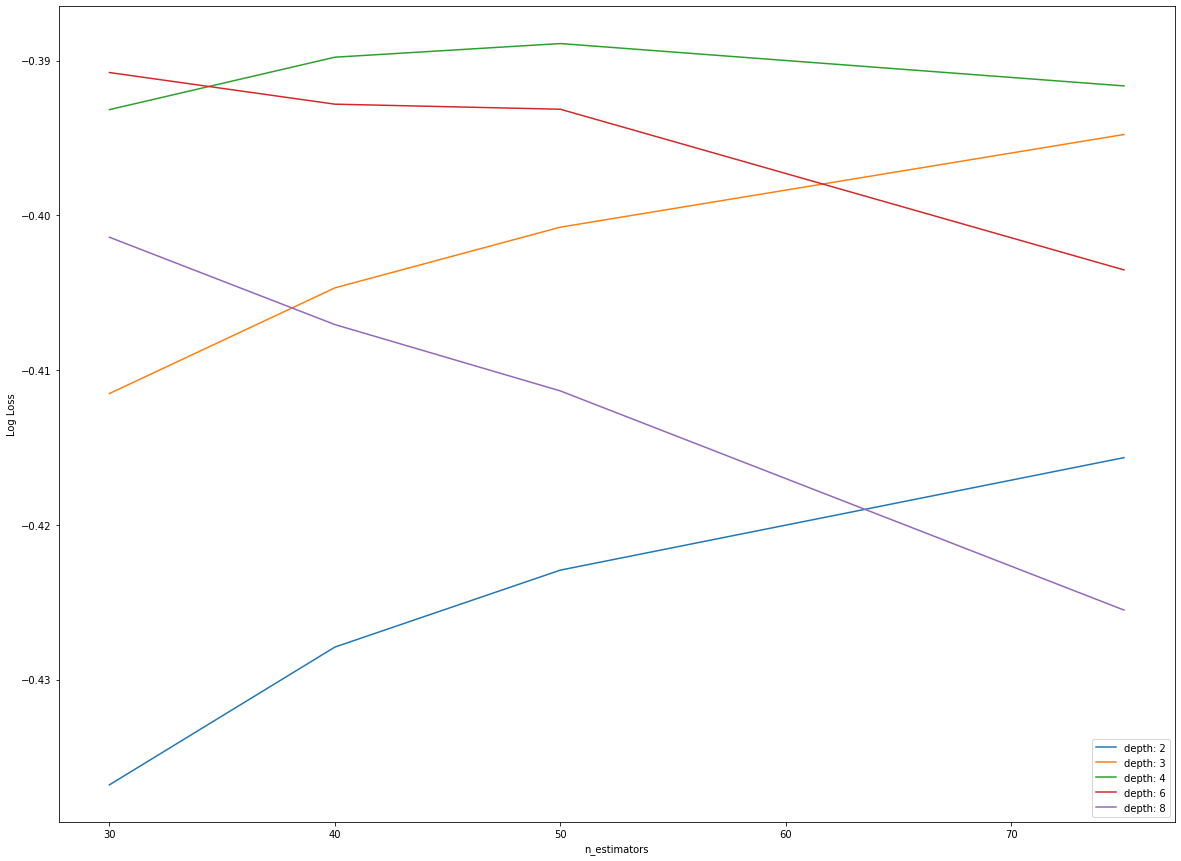

In [26]:
start_time = time.time()
print("\n** INIT TRAINING **\n")
model = xgb.XGBClassifier()
n_estimators = [30, 40, 50, 75]
max_depth = [2, 3, 4, 6, 8]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))

for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
print("\n** TRAINING FINISHED IN ", (time.time()-start_time), " SECONDS")

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

#I tried too many n_estimators and depth and the best result always is 50 and 4.

**Use best estimator**

In [43]:
model = xgb.XGBClassifier(max_depth=4, n_estimators=50)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


**Predict**

In [46]:
predicted_y = model.predict(X_test)

**Create output DataFrame with prediction**

In [47]:
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': predicted_y.astype('bool')})
#output["Transported"].value_counts()
output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2363
False    1914
Name: Transported, dtype: int64

**Export Data for submission**

In [48]:
output.to_csv("XGBClassifier_SubmissionV2.csv")

## **Neural Network - Dont work yet**

In [38]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Accuracy of NN classifier on training set: {:.2f}'
     .format(model.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(model.score(X_test, y_train[0:4277])))

Accuracy of NN classifier on training set: 0.81
Accuracy of NN classifier on test set: 0.50


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## **RandomForestClassifier**

In [50]:
#just for fun lets check the time

start_time = time.time()

params = {'max_depth': [None,10,30,50],
          'n_estimators': [100, 150,200]}

model = RandomForestClassifier()

grid_model = GridSearchCV(model, param_grid=params, scoring="roc_auc")
grid_model.fit(X_train, y_train)

print('Tuned Random Forest best score {}'.format(grid_model.best_score_))
print('Tuned Random Forest best params {}'.format(grid_model.best_estimator_))
print("\nModel training took: ",(time.time()-start_time)," seconds")

Tuned Random Forest best score 0.8707295161903552
Tuned Random Forest best params RandomForestClassifier(max_depth=10, n_estimators=150)

Model training took:  107.56576681137085  seconds


**Now we can predict**

In [51]:
y_pred = grid_model.predict(X_test)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

**Generate the submission DataFrame**

In [52]:
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': y_pred.astype('bool')})
output["Transported"].value_counts()


True     2330
False    1947
Name: Transported, dtype: int64

**Save .csv file**

In [53]:
output.to_csv('RandomForest_SubmissionV2.csv', index=False)

## **KNeigborsClassifier model**

**Check the best n_neighbors value**

In [54]:
start_time = time.time()

error = []

# Calculating MAE error for K values between 1 and 70
for i in range(1, 70):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    mae = mean_absolute_error(y_train[0:4277], pred_i)
    error.append(mae)
    
print("This took: ", (time.time()-start_time), " seconds.")

This took:  63.994038581848145  seconds.


**Plot n values to check the best**

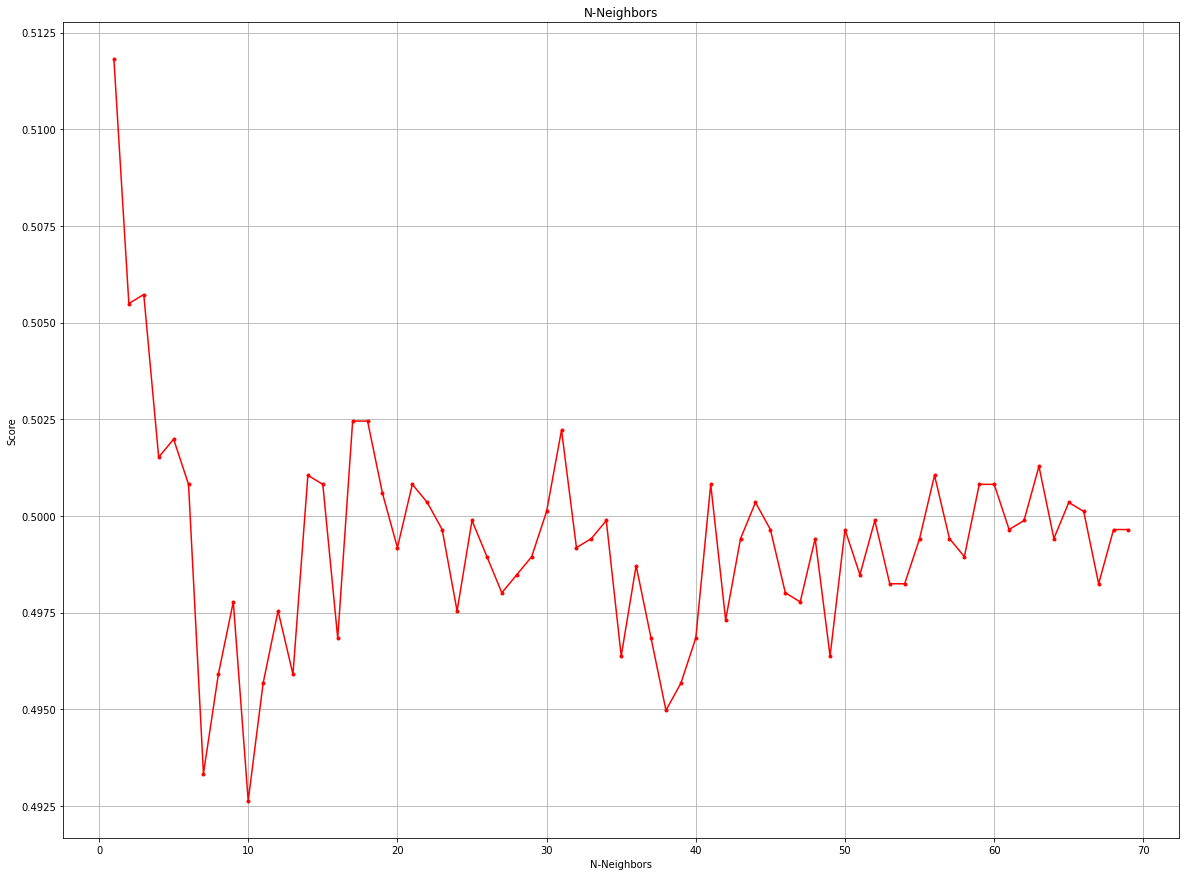

In [55]:
plt.figure()
plt.plot(np.array(range(1,70)),error,".-",color="red")
plt.title("N-Neighbors")
plt.xlabel("N-Neighbors")
plt.ylabel("Score")
plt.grid()
plt.show()

**Choose best n = 1**

In [56]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
pred_i = knn.predict(X_test)

**Prepare output data**

In [57]:
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': pred_i.astype('bool')})
output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2200
False    2077
Name: Transported, dtype: int64

**Create .csv file**

In [58]:
output.to_csv("KNeighbors_SubmissionV2.csv")